# code

In [24]:
import pandas as pd
import numpy as np
import sqlite3
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from ydata_profiling import ProfileReport

import mlflow
import mlflow.sklearn
from sklearn.base import BaseEstimator, TransformerMixin

loan_data = pd.read_csv('loan_data.csv')
connection = sqlite3.connect(":memory:")
cursor = connection.cursor()

cursor.execute("""
CREATE TABLE Person (
    person_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_age FLOAT,
    person_gender TEXT,
    person_education TEXT,
    person_income FLOAT,
    person_emp_exp INTEGER,
    person_home_ownership TEXT
);
""")

cursor.execute("""
CREATE TABLE Loan (
    loan_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    loan_amnt FLOAT,
    loan_intent TEXT,
    loan_int_rate FLOAT,
    loan_percent_income FLOAT,
    loan_status INTEGER,
    FOREIGN KEY (person_id) REFERENCES Person (person_id)
);
""")

cursor.execute("""
CREATE TABLE CreditHistory (
    credit_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    cb_person_cred_hist_length FLOAT,
    credit_score INTEGER,
    previous_loan_defaults_on_file TEXT,
    FOREIGN KEY (person_id) REFERENCES Person (person_id)
);
""")

person_columns = ['person_age', 'person_gender', 'person_education', 
                  'person_income', 'person_emp_exp', 'person_home_ownership']
person_data = loan_data[person_columns].drop_duplicates().reset_index(drop=True)
person_data['person_id'] = range(1, len(person_data) + 1)
person_data.to_sql('Person', connection, if_exists='append', index=False)

loan_columns = ['loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'loan_status']
loan_data_normalized = loan_data.merge(person_data, on=person_columns, how='left')
loan_data_normalized = loan_data_normalized[['person_id'] + loan_columns]
loan_data_normalized.to_sql('Loan', connection, if_exists='append', index=False)

credit_columns = ['cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file']
credit_data = loan_data[credit_columns].join(person_data[['person_id']])
credit_data.to_sql('CreditHistory', connection, if_exists='append', index=False)

print("Person table count:", cursor.execute("SELECT COUNT(*) FROM Person;").fetchone()[0])
print("Loan table count:", cursor.execute("SELECT COUNT(*) FROM Loan;").fetchone()[0])
print("Credit History table count:", cursor.execute("SELECT COUNT(*) FROM CreditHistory;").fetchone()[0])




Person table count: 44983
Loan table count: 45000
Credit History table count: 45000


In [25]:
query = """
SELECT 
    p.person_age,
    p.person_gender,
    p.person_education,
    p.person_income,
    p.person_emp_exp,
    p.person_home_ownership,
    l.loan_amnt,
    l.loan_intent,
    l.loan_int_rate,
    l.loan_percent_income,
    l.loan_status,
    c.cb_person_cred_hist_length,
    c.credit_score,
    c.previous_loan_defaults_on_file
FROM Person p
JOIN Loan l 
ON p.person_id = l.person_id
JOIN CreditHistory c 
ON p.person_id = c.person_id;
"""
loan_data_full = pd.read_sql_query(query, connection)
print(loan_data_full.head())

   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  loan_status  cb_person_cred_hist_length  credit_score  \
0                 0.49            1                  

Loan Status Distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


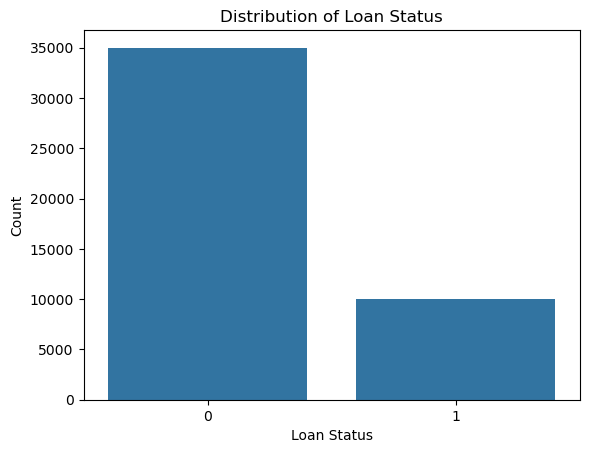

In [26]:
print("Loan Status Distribution:")
print(loan_data_full['loan_status'].value_counts(normalize=True))

sns.countplot(data=loan_data_full, x='loan_status')
plt.title("Distribution of Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

In [27]:
#train/test split with stratification
X = loan_data_full.drop('loan_status', axis=1)  
y = loan_data_full['loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  
)

In [28]:
profile = ProfileReport(loan_data, title="Loan Data Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

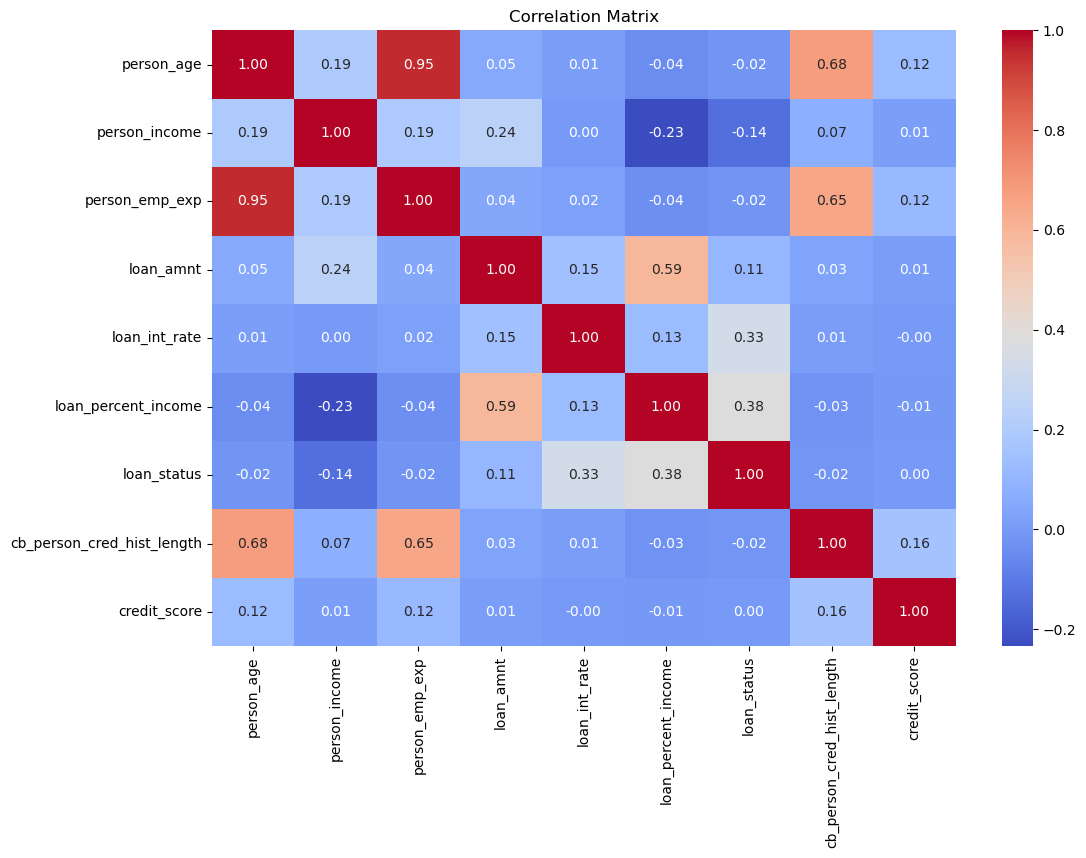

In [29]:
numeric_columns = loan_data_full.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


In [30]:
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(series, lower_percentile)
    upper_bound = np.percentile(series, upper_percentile)
    return np.clip(series, lower_bound, upper_bound)

features_with_outliers = ['person_age', 'person_emp_exp', 'loan_amnt', 'cb_person_cred_hist_length', 'credit_score']
for feature in features_with_outliers:
    loan_data[feature] = cap_outliers(loan_data[feature])

loan_data.drop(columns=['person_emp_exp'], inplace=True)

numerical_features = ['person_age', 'person_income', 'loan_amnt', 
                      'loan_int_rate', 'loan_percent_income', 
                      'cb_person_cred_hist_length', 'credit_score']

scaler = StandardScaler()
loan_data[numerical_features] = scaler.fit_transform(loan_data[numerical_features])

categorical_columns = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(loan_data[categorical_columns])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
loan_data = pd.concat([loan_data.drop(columns=categorical_columns), encoded_df], axis=1)
print(loan_data.head())


   person_age  person_income  loan_amnt  loan_int_rate  loan_percent_income  \
0   -1.014624      -0.104090   3.061053       1.683039             4.016394   
1   -1.193116      -0.846005  -1.364261       0.044782            -0.684829   
2   -0.479148      -0.844065  -0.656065       0.625557             3.443074   
3   -0.836132      -0.007039   3.061053       1.417829             3.443074   
4   -0.657640      -0.176371   3.061053       1.095549             4.475050   

   cb_person_cred_hist_length  credit_score  loan_status  person_gender_male  \
0                   -0.766708     -1.445292            1                 0.0   
1                   -1.038860     -2.594200            0                 0.0   
2                   -0.766708      0.046274            1                 0.0   
3                   -1.038860      0.852526            1                 0.0   
4                   -0.494555     -0.941384            1                 1.0   

   person_education_Bachelor  ...  person_ed

In [31]:
loan_data.isna().sum()

person_age                            0
person_income                         0
loan_amnt                             0
loan_int_rate                         0
loan_percent_income                   0
cb_person_cred_hist_length            0
credit_score                          0
loan_status                           0
person_gender_male                    0
person_education_Bachelor             0
person_education_Doctorate            0
person_education_High School          0
person_education_Master               0
person_home_ownership_OTHER           0
person_home_ownership_OWN             0
person_home_ownership_RENT            0
loan_intent_EDUCATION                 0
loan_intent_HOMEIMPROVEMENT           0
loan_intent_MEDICAL                   0
loan_intent_PERSONAL                  0
loan_intent_VENTURE                   0
previous_loan_defaults_on_file_Yes    0
dtype: int64

In [32]:
# Set environment variables for MLflow and DagsHub
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/tejaswini161/my-first-repo.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = "tejaswini161"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "86ddd17b46cb18df8455f352e782088c0bcf0652"

In [34]:
X = loan_data.drop(columns=['loan_status'])  
y = loan_data['loan_status'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numeric_features = X_train.columns.tolist()

def shift_positive(X):
    min_val = X.min(axis=0)
    shift = np.abs(min_val) + 1 
    return X + shift

# numeric_imputer = SimpleImputer(strategy='mean')

numeric_transformer = Pipeline(steps=[
    ('shift_positive', FunctionTransformer(shift_positive, validate=False)), 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10], 
    'classifier__solver': ['lbfgs', 'liblinear']  
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=skf,  
    n_jobs=-1
)

mlflow.set_experiment("Loan Prediction Experiment #1")
with mlflow.start_run():
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)
    cv_results = grid_search.cv_results_
    cv_f1_mean = np.mean(cv_results['mean_test_score'])
    cv_f1_std = np.std(cv_results['mean_test_score'])
    mlflow.log_metric("cv_f1_mean", cv_f1_mean)
    mlflow.log_metric("cv_f1_std", cv_f1_std)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1", test_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.sklearn.log_model(best_model, "loan_prediction_model")

print(f"Best Parameters: {best_params}")
print(f"Cross-Validation F1 Score: Mean = {cv_f1_mean:.4f}, Std = {cv_f1_std:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")



🏃 View run receptive-slug-204 at: https://dagshub.com/tejaswini161/my-first-repo.mlflow/#/experiments/0/runs/7a347cb8f9344601af244a48dabb7bc8
🧪 View experiment at: https://dagshub.com/tejaswini161/my-first-repo.mlflow/#/experiments/0


AttributeError: 'Pipeline' object has no attribute 'transform_input'

In [ ]:
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=500),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGB Classifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mlflow.set_experiment("Loan Prediction Experiment #2")

for name, clf in classifiers.items():
    with mlflow.start_run(run_name=name):
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])
        f1_scorer = make_scorer(f1_score)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
        mlflow.log_param("model", name)
        mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
        mlflow.log_metric("cv_f1_std", np.std(cv_scores))
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        test_f1 = f1_score(y_test, y_pred)
        mlflow.log_metric("test_f1", test_f1)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mlflow.log_metric("true_positive", tp)
        mlflow.log_metric("true_negative", tn)
        mlflow.log_metric("false_positive", fp)
        mlflow.log_metric("false_negative", fn)
        mlflow.sklearn.log_model(pipeline, f"{name}_model")
        
        print(f"{name} Results:")
        print(f"CV F1 Score: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")

In [ ]:
mlflow.set_experiment("Loan Prediction Experiment #3")
with mlflow.start_run():
    mlflow.log_param("feature_engineering", [
        "income_to_loan_ratio = person_income / loan_amnt",
        "employment_to_age_ratio = person_emp_exp / (person_age + 1)",
        "interest_to_income_ratio = loan_int_rate / (person_income + 1)"
    ])
    f1_scorer = make_scorer(f1_score)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
    mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
    mlflow.log_metric("cv_f1_std", np.std(cv_scores))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1", test_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.sklearn.log_model(pipeline, "loan_prediction_model_with_feature_engineering")

    print("Feature Engineering:")
    print(f"CV F1 Score: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")

In [ ]:
X = loan_data.drop(columns=['loan_status'])  
y = loan_data['loan_status'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class VarianceThresholdSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.selector = None

    def fit(self, X, y=None):
        self.selector = VarianceThreshold(threshold=self.threshold)
        self.selector.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.selector.transform(X), columns=X.columns[self.selector.get_support()])

class CorrelationThresholdSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.85):
        self.threshold = threshold
        self.to_drop = []

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        return X.drop(columns=self.to_drop)

class FeatureImportanceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, model=RandomForestClassifier(random_state=42)):
        self.model = model
        self.selected_features = []

    def fit(self, X, y):
        self.model.fit(X, y)
        importances = self.model.feature_importances_
        threshold = np.mean(importances)
        self.selected_features = X.columns[importances >= threshold]
        return self

    def transform(self, X):
        return X[self.selected_features]

feature_selection_pipeline = Pipeline(steps=[
    ('variance_threshold', VarianceThresholdSelector(threshold=0.01)),
    ('correlation_threshold', CorrelationThresholdSelector(threshold=0.85)),
    ('feature_importance', FeatureImportanceSelector(model=RandomForestClassifier(random_state=42)))
])

pipeline = Pipeline(steps=[
    ('feature_selection', feature_selection_pipeline),
    ('classifier', LogisticRegression(random_state=42))
])

f1_scorer = make_scorer(f1_score)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=f1_scorer, n_jobs=-1)

mlflow.set_experiment("Loan Prediction Experiment #4")
with mlflow.start_run():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
    mlflow.log_metric("cv_f1_std", np.std(cv_scores))
    mlflow.log_metric("test_f1", test_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.sklearn.log_model(pipeline, "loan_prediction_model_with_feature_selection")
print("Feature Selection:")
print(f"CV F1 Score: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.savefig("scree_plot.png", dpi=300) 
plt.show()

n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=n_components)), 
    ('classifier', LogisticRegression(random_state=42))
])

f1_scorer = make_scorer(f1_score)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=f1_scorer, n_jobs=-1)

mlflow.set_experiment("Loan Prediction Experiment #5")
with mlflow.start_run():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_param("n_components", n_components)
    mlflow.log_artifact("scree_plot.png", artifact_path="plots")
    mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
    mlflow.log_metric("cv_f1_std", np.std(cv_scores))
    mlflow.log_metric("test_f1", test_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.sklearn.log_model(pipeline, "loan_prediction_model_with_pca")

print(f"CV F1 Score: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")

In [ ]:

n_components = 17 

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])
f1_scorer = make_scorer(f1_score)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=f1_scorer, n_jobs=-1)

mlflow.set_experiment("Loan Prediction Experiment #6")
with mlflow.start_run():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_param("n_components", n_components)
    mlflow.log_param("classifier", "RandomForestClassifier")
    mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
    mlflow.log_metric("cv_f1_std", np.std(cv_scores))
    mlflow.log_metric("test_f1", test_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.sklearn.log_model(pipeline, "loan_prediction_model_custom_experiment")
    
print(f"Custom Experiment Results:")
print(f"CV F1 Score: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")


In [ ]:
print(y.value_counts(normalize=True))


In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

f1_scorer = make_scorer(f1_score)
cv_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=3, scoring=f1_scorer, n_jobs=-1)

mlflow.set_experiment("Loan Prediction Experiment #7")
with mlflow.start_run():
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_param("oversampling_technique", "SMOTE")
    mlflow.log_param("classifier", "GradientBoostingClassifier")
    mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
    mlflow.log_metric("cv_f1_std", np.std(cv_scores))
    mlflow.log_metric("test_f1", test_f1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.sklearn.log_model(pipeline, "loan_prediction_model_with_smote")

print(f"Custom Experiment Results:")
print(f"CV F1 Score: Mean = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Confusion Matrix: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}")


In [ ]:
experiments = [
    'Experiment #1: Logistic Regression',
    'Experiment #2.1: Logistic Regression',
    'Experiment #2.2: Ridge Classifier',
    'Experiment #2.3: Random Forest',
    'Experiment #2.4: XGB Classifier',
    'Experiment #3: Feature Engineering',
    'Experiment #4: Feature Selection',
    'Experiment #5: PCA + Logistic Regression',
    'Experiment #6: Random Forest',
    'Experiment #7: SMOTE + Gradient Boosting'
]

cv_f1_means = [
    0.7570,  # Experiment #1
    0.7596,  # Experiment #2.1: Logistic Regression
    0.7415,  # Experiment #2.2: Ridge Classifier
    0.8236,  # Experiment #2.3: Random Forest
    0.8350,  # Experiment #2.4: XGB Classifier
    0.7881,  # Experiment #3
    0.7479,  # Experiment #4
    0.7595,  # Experiment #5
    0.8255,  # Experiment #6
    0.9124   # Experiment #7
]

cv_f1_stds = [
    0.0037,  # Experiment #1
    0.0085,  # Experiment #2.1: Logistic Regression
    0.0118,  # Experiment #2.2: Ridge Classifier
    0.0132,  # Experiment #2.3: Random Forest
    0.0152,  # Experiment #2.4: XGB Classifier
    0.0113,  # Experiment #3
    0.0051,  # Experiment #4
    0.0105,  # Experiment #5
    0.0029,  # Experiment #6
    0.0209   # Experiment #7
]

# Test F1 Scores
test_f1_scores = [
    0.7688,  # Experiment #1
    0.7693,  # Experiment #2.1: Logistic Regression
    0.7591,  # Experiment #2.2: Ridge Classifier
    0.8279,  # Experiment #2.3: Random Forest
    0.8496,  # Experiment #2.4: XGB Classifier
    0.8000,  # Experiment #3
    0.7624,  # Experiment #4
    0.7681,  # Experiment #5
    0.8273,  # Experiment #6
    0.7924   # Experiment #7
]

plt.figure(figsize=(12, 6))
plt.barh(experiments, cv_f1_means, xerr=cv_f1_stds, color='skyblue', edgecolor='black')
plt.xlabel('F1-Score (Mean ± Std)')
plt.title('Cross-Validation F1-Scores Across Experiments')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("cv_f1_scores.png", dpi=300) 
plt.show()


plt.figure(figsize=(12, 6))
plt.barh(experiments, test_f1_scores, color='lightgreen', edgecolor='black')
plt.xlabel('F1-Score')
plt.title('Test F1-Scores Across Experiments')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("test_f1_scores.png", dpi=300)  
plt.show()


In [ ]:
print('Best Model is XGB Classifier as it achieves the highest test F1-score (0.8496), indicating the best real-world generalization on unseen data.')
print('With a mean F1-score of 0.8350 and standard deviation of 0.0152, it is consistent during cross-validation.')
print('Unlike Experiment #7 (SMOTE + Gradient Boosting), which shows potential overfitting that is high cross-validation but lower test F1, XGB Classifier provides a reliable balance between training and test performance.')

In [ ]:

feature_selection_pipeline.fit(X_train, y_train)

variance_selected_features = feature_selection_pipeline.named_steps['variance_threshold'].selector.get_support()
variance_features = X_train.columns[variance_selected_features]
print("Features after Variance Threshold:")
print(variance_features.tolist())

correlation_dropped_features = feature_selection_pipeline.named_steps['correlation_threshold'].to_drop
correlation_features = variance_features.difference(correlation_dropped_features)
print("\nFeatures after Correlation Threshold:")
print(correlation_features.tolist())

importance_selected_features = feature_selection_pipeline.named_steps['feature_importance'].selected_features
print("\nTop Features after Feature Importance:")
print(importance_selected_features.tolist())

top_features = importance_selected_features


In [ ]:
import joblib
final_model = XGBClassifier(random_state=42)
final_model.fit(X[top_features],y)
joblib.dump(final_model, "loan_prediction_model.pkl")
print("Model saved as loan_prediction_model.pkl")
